In [3]:
import torch

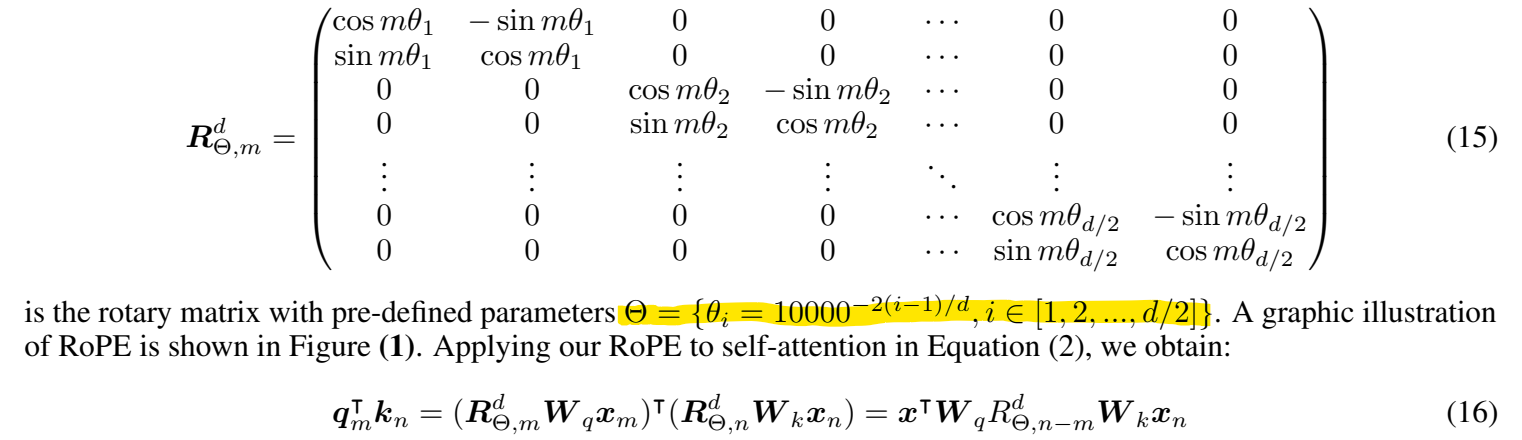

In [4]:
def precompute_theta_pos_frequencies(head_dim:int, seq_len:int, device:str, theta:float=10000.0):
    assert head_dim % 2 == 0, "Dimension (divided with head) must be divisible by 2"
    
    theta_numerator = torch.arange(0, head_dim, 2).float()
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device)
    m = torch.arange(seq_len, device=device)
    freqs = torch.outer(m, theta).float() # (seq_len) outer product* (head_dim / 2) -> (seq_len, head_dim/2)
    
    # torch.polar = abs⋅cos(angle)+abs⋅sin(angle)⋅j
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

In [31]:
head_dim = 4
seq_len = 24
device = 'cpu'

freqs_complex = precompute_theta_pos_frequencies(head_dim, seq_len, device)
freqs_complex

tensor([[ 1.0000+0.0000j,  1.0000+0.0000j],
        [ 0.5403+0.8415j,  0.9999+0.0100j],
        [-0.4161+0.9093j,  0.9998+0.0200j],
        [-0.9900+0.1411j,  0.9996+0.0300j],
        [-0.6536-0.7568j,  0.9992+0.0400j],
        [ 0.2837-0.9589j,  0.9988+0.0500j],
        [ 0.9602-0.2794j,  0.9982+0.0600j],
        [ 0.7539+0.6570j,  0.9976+0.0699j],
        [-0.1455+0.9894j,  0.9968+0.0799j],
        [-0.9111+0.4121j,  0.9960+0.0899j],
        [-0.8391-0.5440j,  0.9950+0.0998j],
        [ 0.0044-1.0000j,  0.9940+0.1098j],
        [ 0.8439-0.5366j,  0.9928+0.1197j],
        [ 0.9074+0.4202j,  0.9916+0.1296j],
        [ 0.1367+0.9906j,  0.9902+0.1395j],
        [-0.7597+0.6503j,  0.9888+0.1494j],
        [-0.9577-0.2879j,  0.9872+0.1593j],
        [-0.2752-0.9614j,  0.9856+0.1692j],
        [ 0.6603-0.7510j,  0.9838+0.1790j],
        [ 0.9887+0.1499j,  0.9820+0.1889j],
        [ 0.4081+0.9129j,  0.9801+0.1987j],
        [-0.5477+0.8367j,  0.9780+0.2085j],
        [-1.0000-0.0089j,  0.975

/tmp/ipykernel_144143/3454520492.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pe = np.array(pe, dtype=float)
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1151: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


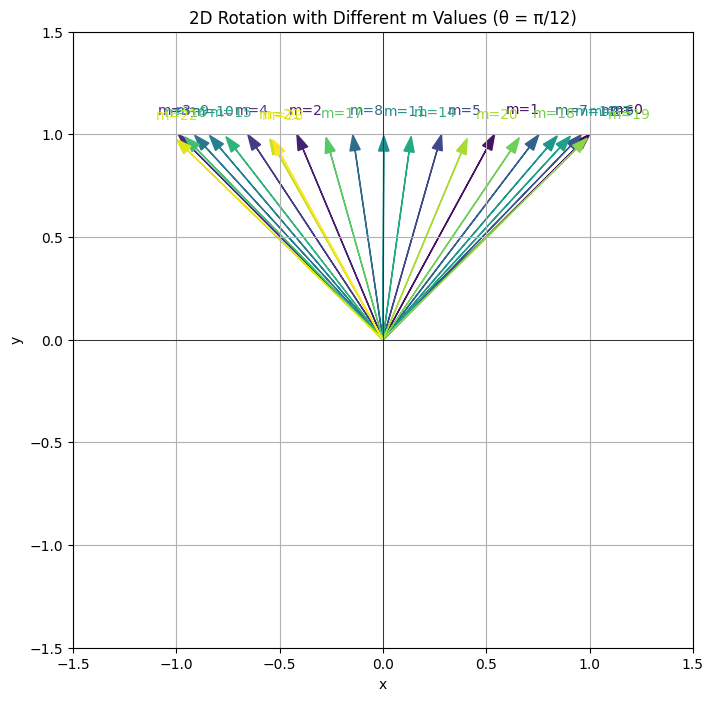

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,8))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
colors = plt.cm.viridis(np.linspace(0, 1, len(freqs_complex)))

# 각 m에 대해 회전 행렬을 적용한 벡터 그리기
gap = 1
for i, pe in enumerate(freqs_complex[::gap]):
    pe = np.array(pe, dtype=float)
    plt.arrow(0, 0, pe[0], pe[1], head_width=0.05,
              color=colors[i*gap], length_includes_head=True)
    plt.text(pe[0]*1.1, pe[1]*1.1, f"m={i*gap}", color=colors[i*gap], fontsize=10)

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title("2D Rotation with Different m Values (θ = π/12)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [33]:
def apply_rotary_embeddings(x: torch.Tensor, freqs_complex:torch.Tensor, device:str):
    # (B, seq_len, num_heads, head_dim) -> (B, seq_len, num_heads, head_dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # (seq_len, head_dim/2) -> (1, seq_len, 1, head_dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # (B, seq_len, num_heads, head_dim/2) * (1, seq_len, 1, head_dim/2) = (B, seq_len, num_heads, head_dim/2)
    x_rotated = x_complex * freqs_complex
    # (B, seq_len, num_heads, head_dim/2) -> (B, seq_len, num_heads, head_dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, seq_len, num_heads, head_dim/2, 2) -> (B, seq_len, num_heads, head)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)    

In [43]:
x_dummy = torch.rand((1, seq_len, seq_len // head_dim, head_dim))

x_out = apply_rotary_embeddings(x_dummy, freqs_complex, device)
x_out.shape

torch.Size([1, 24, 6, 4])